In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchinfo import summary
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch.utils.tensorboard import SummaryWriter

# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## MNIST Dataset

In [2]:
VAL_SIZE = 0.1
BATCH_SIZE = 64

# download the training and testing datasets
train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./root',
                                          train=False,
                                          transform=transforms.ToTensor(),
                                          download=True)

# split the training set into train and validation sets
train_indices, val_indices, _, _ = train_test_split(range(len(train_dataset)),
                                                    train_dataset.targets,
                                                    stratify=train_dataset.targets,
                                                    test_size=VAL_SIZE)

train_split = Subset(train_dataset, train_indices)
val_split = Subset(train_dataset, val_indices)

# now create the batches of the train, val, test sets
train_loader = DataLoader(train_split, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_split, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

844
94
157


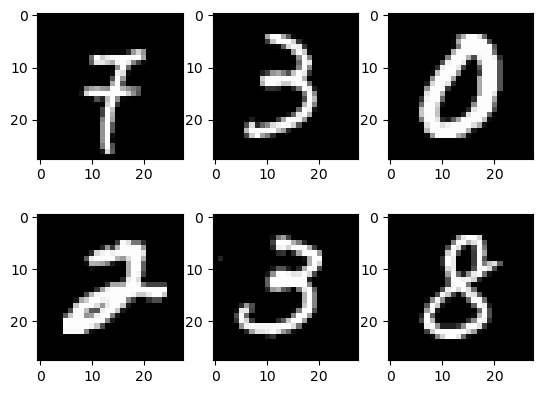

In [3]:
# show some samples from test set

samples = iter(test_loader)
sample_data, sample_targets = next(samples)

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(sample_data[i][0], cmap='gray')
plt.show()

## Model

In [4]:
# fully connected neural network with one hidden layer
class FCNeuralNet(nn.Module):
    def __init__(self):
        super(FCNeuralNet, self).__init__()
        self.input_size = 28*28
        self.num_classes = 10
        self.hidden_size = 512
        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        self.fc2 = nn.Linear(self.hidden_size, self.num_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        # no activation function here (no softmax) because the loss implement it directly
        return x

In [5]:
model = FCNeuralNet().to(device)
summary(model, input_size=(BATCH_SIZE, 1, 28*28))

Layer (type:depth-idx)                   Output Shape              Param #
FCNeuralNet                              [64, 1, 10]               --
├─Linear: 1-1                            [64, 1, 512]              401,920
├─ReLU: 1-2                              [64, 1, 512]              --
├─Linear: 1-3                            [64, 1, 10]               5,130
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
Total mult-adds (M): 26.05
Input size (MB): 0.20
Forward/backward pass size (MB): 0.27
Params size (MB): 1.63
Estimated Total Size (MB): 2.10

In [6]:
# loss and optmizer
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [7]:
# training
def train(model, trainloader, optimizer, criterion):
    # model.train() is a kind of switch for some specific layers/parts of the model that behave differently 
    # during training time.(For example, Dropouts Layers, BatchNorm Layers, etc.)
    model.train()
    
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        
        # from each batch retrieve the images and labels
        image, labels = data
        #labels = labels - 1
        image = image.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # zeros the gradient of the previous iteration
        optimizer.zero_grad()
        
        # forward pass
        outputs = model(image)
        
        # calculate the loss
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        
        # calculate the accuracy
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        
        # apply the gradient and update the weights
        loss.backward()
        optimizer.step()
    
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))

    return epoch_loss, epoch_acc

In [8]:
# test
def test(model, testloader, criterion):
    # model.eval() is a kind of switch for some specific layers/parts of the model that behave differently 
    # during validation time.(For example, Dropouts Layers, BatchNorm Layers, etc.)
    # combine with torch.no_grad() to turn of the gradient computation
    model.eval()
    
    # we need two lists to keep track of class-wise accuracy
    class_correct = list(0. for i in range(10+1))
    class_total = list(0. for i in range(10+1))
    
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            
            # from each batch retrieve the images and labels
            image, labels = data
            #labels = labels - 1
            image = image.reshape(-1, 28*28).to(device)
            labels = labels.to(device)
            
            # forward pass
            outputs = model(image)
            
            # calculate the loss
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()

            # calculate the accuracy for each class
            """
            correct  = (preds == labels).squeeze()
            for i in range(len(preds)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1
            """
        
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))

    return epoch_loss, epoch_acc

"""
    # print the accuracy for each class after evey epoch
    # the values should increase as the training goes on
    print('\n')
    for i in range(183):
        print(f"Accuracy of digit {i+1}: {100*class_correct[i]/class_total[i]}")
""";

## Training and Validation the Model

In [9]:
writer = SummaryWriter() # writer for the tensorboard
EPOCHS = 5 #100

for epoch in range(EPOCHS):
    logs = {}
    print(f"[INFO]: Epoch {epoch+1} of {EPOCHS}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader, optimizer, criterion)
    print('\n')
    val_epoch_loss, val_epoch_acc = test(model, val_loader, criterion)
    
    
    print('\n')
    print(f"training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}%")
    print(f"validation loss: {val_epoch_loss:.3f}, validation acc: {val_epoch_acc:.3f}%")
    print('-'*50)

    writer.add_scalar("train/training_loss", train_epoch_loss, epoch+1)
    writer.add_scalar("train/training_acc", train_epoch_acc, epoch+1)
    writer.flush()

    writer.add_scalar("valid/val_loss", val_epoch_loss, epoch+1)
    writer.add_scalar("valid/val_acc", val_epoch_acc, epoch+1)
    writer.flush()

[INFO]: Epoch 1 of 5
Training


  0%|          | 0/844 [00:00<?, ?it/s]



Validation


  0%|          | 0/94 [00:00<?, ?it/s]



training loss: 2.213, training acc: 41.628%
validation loss: 2.107, validation acc: 64.717%
--------------------------------------------------
[INFO]: Epoch 2 of 5
Training


  0%|          | 0/844 [00:00<?, ?it/s]



Validation


  0%|          | 0/94 [00:00<?, ?it/s]



training loss: 1.982, training acc: 69.769%
validation loss: 1.848, validation acc: 73.400%
--------------------------------------------------
[INFO]: Epoch 3 of 5
Training


  0%|          | 0/844 [00:00<?, ?it/s]



Validation


  0%|          | 0/94 [00:00<?, ?it/s]



training loss: 1.698, training acc: 74.359%
validation loss: 1.547, validation acc: 76.900%
--------------------------------------------------
[INFO]: Epoch 4 of 5
Training


  0%|          | 0/844 [00:00<?, ?it/s]



Validation


  0%|          | 0/94 [00:00<?, ?it/s]



training loss: 1.403, training acc: 77.480%
validation loss: 1.269, validation acc: 79.250%
--------------------------------------------------
[INFO]: Epoch 5 of 5
Training


  0%|          | 0/844 [00:00<?, ?it/s]



Validation


  0%|          | 0/94 [00:00<?, ?it/s]



training loss: 1.158, training acc: 79.961%
validation loss: 1.056, validation acc: 81.917%
--------------------------------------------------


In [10]:
"""
# save the trained model to disk
torch.save({
            'epoch': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, './model.pth')
""";